In [1]:
from causal_world.evaluation.evaluation import EvaluationPipeline
from causal_world.intervention_actors import RandomInterventionActorPolicy, GoalInterventionActorPolicy, CurriculumInterventionActorPolicy
from causal_world.benchmark.benchmarks import PUSHING_BENCHMARK, PICKING_BENCHMARK, \
    PICK_AND_PLACE_BENCHMARK, STACKING2_BENCHMARK
from causal_world.task_generators.task import generate_task
import causal_world.viewers.task_viewer as viewer
import causal_world.evaluation.visualization.visualiser as vis

from scripts.util import utils as utils, utils_baselines as utils_baselines
import argparse
import os
import tensorflow as tf
import wandb

c:\users\psiml8\causalworld\causal_world\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [2]:
%reload_ext tensorboard

In [3]:
import tensorflow as tf
import datetime


In [4]:
from stable_baselines import PPO1


def baseline_model(model_num, task):
    if task == 'pushing':
        benchmarks = utils.sweep('benchmarks', [PUSHING_BENCHMARK])
        task_configs = [{
            'task_configs': {
                'variables_space': 'space_a',
                'fractional_reward_weight': 1,
                'dense_reward_weights': [750, 250, 0]
            }
        }]
    elif task == 'picking':
        benchmarks = utils.sweep('benchmarks', [PICKING_BENCHMARK])
        task_configs = [{
            'task_configs': {
                'variables_space': 'space_a',
                'fractional_reward_weight': 1,
                'dense_reward_weights': [250, 0, 125,
                                         0, 750, 0,
                                         0, 0.005]
            }
        }]
    elif task == 'pick_and_place':
        benchmarks = utils.sweep('benchmarks', [PICK_AND_PLACE_BENCHMARK])
        task_configs = [{
            'task_configs': {
                'variables_space': 'space_a',
                'fractional_reward_weight': 1,
                'dense_reward_weights': [750, 50, 250, 0, 0.005]
            }
        }]
    elif task == 'stacking2':
        benchmarks = utils.sweep('benchmarks', [STACKING2_BENCHMARK])
        task_configs = [{
            'task_configs': {
                'variables_space': 'space_a',
                'fractional_reward_weight': 1,
                'dense_reward_weights': [750, 250,
                                         250, 125,
                                         0.005]
            }
        }]
    else:
        benchmarks = utils.sweep('benchmarks', [PUSHING_BENCHMARK])
        task_configs = [{
            'task_configs': {
                'variables_space': 'space_a',
                'fractional_reward_weight': 1,
                'dense_reward_weights': [750, 250, 0]
            }
        }]

    world_params = [{
        'world_params': {
            'skip_frame': 3,
            'enable_visualization': False,
            'observation_mode': 'structured',
            'normalize_observations': True,
            'action_mode': 'joint_positions'
        }
    }]

    net_layers = utils.sweep('NET_LAYERS', [[256, 256]])
    world_seed = utils.sweep('world_seed', [0])
    NUM_RANDOM_SEEDS = 5
    random_seeds = utils.sweep('seed', list(range(NUM_RANDOM_SEEDS)))

    ppo = {'num_of_envs': 20,
           'algorithm': 'PPO',
           'validate_every_timesteps': int(20000),
           'total_time_steps': int(10000000),
           'train_configs': {
               "gamma": 0.99,
               "n_steps": int(1200 / 20),
               "ent_coef": 0.01,
               "learning_rate": 0.00025,
               "vf_coef": 0.5,
               "max_grad_norm": 0.5,
               "nminibatches": 40,
               "noptepochs": 4
           }}

    sac = {'num_of_envs': 1,
           'algorithm': 'SAC',
           'validate_every_timesteps': int(50000),
           'total_time_steps': int(1e6),
           'train_configs': {
               "gamma": 0.95,
               "tau": 1e-3,
               "ent_coef": 1e-3,
               "target_entropy": 'auto',
               "learning_rate":  1e-4,
               "buffer_size": 100000,
               "learning_starts": 1000,
               "batch_size": 256
           }}

    td3 = {'num_of_envs': 1,
           'algorithm': 'TD3',
           'validate_every_timesteps': int(500000),
           'total_time_steps': int(10000000),
           'train_configs': {
               "gamma": 0.96,
               "tau": 0.02,
               "learning_rate": 1e-4,
               "buffer_size": 500000,
               "learning_starts": 1000,
               "batch_size": 128}}

    algorithms = [sac]

    curriculum_kwargs_1 = {'intervention_actors': [], 'actives': []}
    curriculum_kwargs_2 = {
        'intervention_actors': [GoalInterventionActorPolicy()],
        'actives': [(0, 1e9, 1, 0)]
    }
    curriculum_kwargs_3 = {
        'intervention_actors': [RandomInterventionActorPolicy()],
        'actives': [(0, 1e9, 1, 0)]
    }
    curriculum_kwargs_4 = {
        'intervention_actors': [CurriculumInterventionActorPolicy()],
        'actives': [(0, 1e9, 1, 0)]
    }
    curriculum_kwargs = [
        curriculum_kwargs_1
    ]

    return utils.outer_product([
        benchmarks, world_params, task_configs, algorithms, curriculum_kwargs,
        random_seeds, world_seed, net_layers
    ])[model_num]


c:\Users\psiml8\Anaconda3\envs\causal_world\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [5]:
parser = argparse.ArgumentParser()
parser.add_argument("--model_num",
                    required=True,
                    default=0,
                    help="model number")
parser.add_argument("--task",
                    required=True,
                    default='pushing',
                    help="possible tasks: pushing, picking, pick_and_place, stacking2")
parser.add_argument("--output_path", required=True, help="output path")
# parser.add_argument('--tensorboard', help="tensorboard logging")

tensorboard_logging = True


In [6]:
model_num = 4
task = "pushing"
output_path = "experiments-pushing"
output_path = os.path.join(output_path, str(model_num))
try:
    os.makedirs(output_path)
except FileExistsError: 
    print("Folder '{}' already exists. Will try to load existing checkpoints".format(output_path))

model_settings = baseline_model(model_num, task)

model = utils_baselines.train_model(model_settings, output_path, tensorboard_logging)

Folder 'experiments-pushing\3' already exists. Will try to load existing checkpoints
Folder 'experiments-pushing\3\model' already exists


: 

In [7]:
def policy_fn(obs, prev_action=None, prev_reward=None):
        return model.predict(obs, deterministic=True)[0]

In [8]:
animation_path = os.path.join(output_path, 'animation')
os.makedirs(animation_path)
viewer.record_video_of_policy(task=generate_task(
    task_generator_id=model_settings['benchmarks']['task_generator_id'],
    **model_settings['task_configs']),
    world_params=model_settings['world_params'],
    policy_fn=policy_fn,
    file_name=os.path.join(
        animation_path, "policy"),
    number_of_resets=1,
    max_time_steps=600)

In [9]:
evaluation_path = os.path.join(output_path, 'evaluation',
                                   'time_steps_{}'.format(model_settings['total_time_steps']))
os.makedirs(evaluation_path)

evaluation_protocols = model_settings['benchmarks']['evaluation_protocols']

evaluator = EvaluationPipeline(evaluation_protocols=evaluation_protocols,
                                tracker_path=output_path,
                                initial_seed=0)
scores = evaluator.evaluate_policy(policy_fn, fraction=1.0)


INFO:root:Applying the following protocol now, P0
INFO:root:Applying the following protocol now, P1
INFO:root:Applying the following protocol now, P2
INFO:root:Applying the following protocol now, P3
INFO:root:Applying the following protocol now, P4
INFO:root:Applying the following protocol now, P5
INFO:root:Applying the following protocol now, P6
INFO:root:Applying the following protocol now, P7
INFO:root:Applying the following protocol now, P8
INFO:root:Applying the following protocol now, P9
INFO:root:Applying the following protocol now, P10
INFO:root:Applying the following protocol now, P11


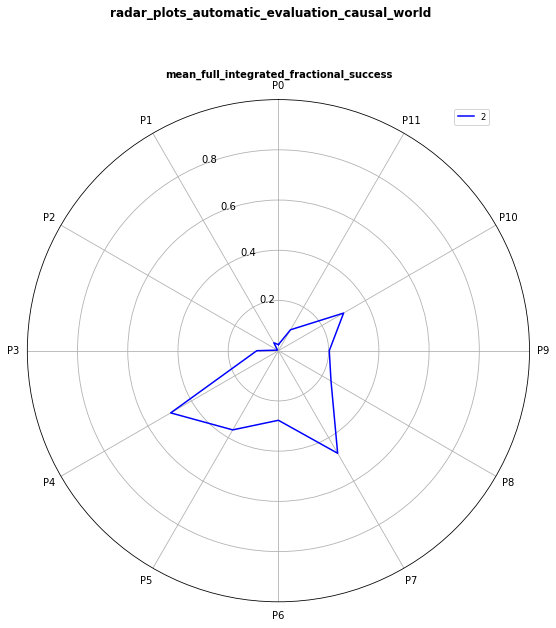

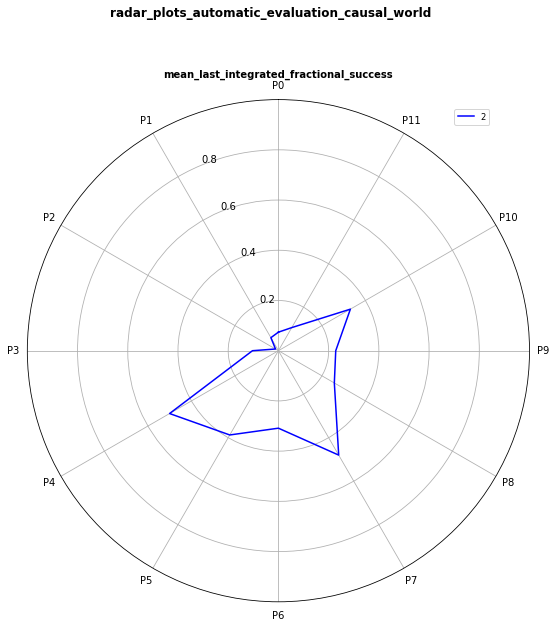

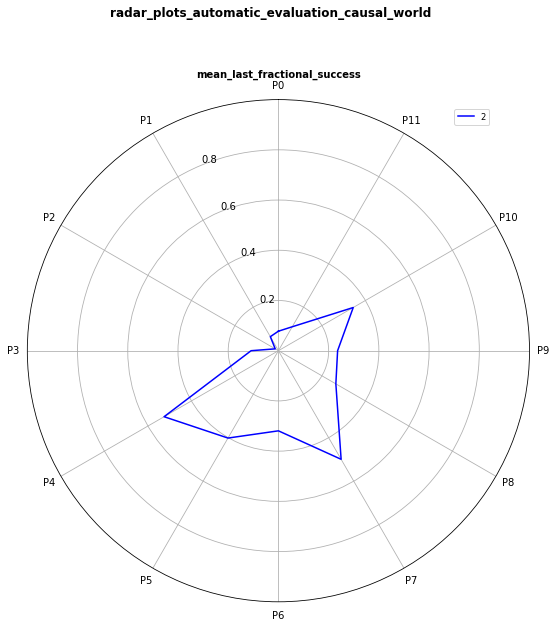

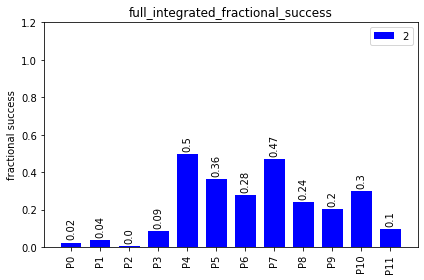

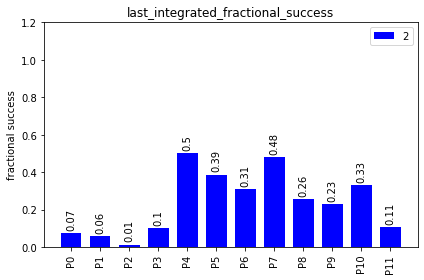

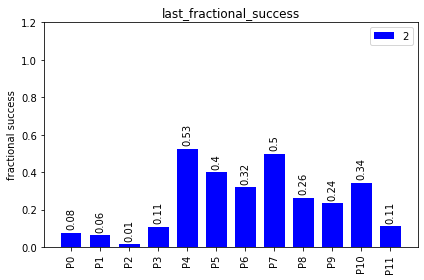

In [10]:
results_model = dict()
results_model.update(scores)
results_model.update(model_settings)
results_model.update({'model_num': model_num})
del results_model['benchmarks']
file_name_results_model = os.path.join(evaluation_path, 'results_model.json')
utils.save_model_settings(file_name_results_model, results_model)
evaluator.save_scores(evaluation_path)
experiments = dict()
experiments[str(model_num)] = scores
vis.generate_visual_analysis(evaluation_path, experiments=experiments)